In [2]:
from torch.utils.data import Dataset
from typing import Tuple
import torch


class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

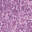

13000


In [3]:
dataset = TaskDataset()

if __name__ == "__main__":
    dataset = torch.load("../data/ModelStealingPub.pt")
    display(dataset.imgs[0])
    #print(dataset.ids, dataset.imgs, dataset.labels)
    print(len(dataset.imgs))

In [4]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
 
print("the unique values from 1st list is")
uniq = unique(dataset.labels)
print(len(uniq))

the unique values from 1st list is
50


In [6]:
from imgaug import augmenters as iaa
import numpy as np

class LabelDict:

    def __init__(self, labels):
        self.codes2labels_dct = []
        self.labels2codes_dct = {}
        i = 0
        for l in labels:
            if not self.labels2codes_dct.get(l):
                self.labels2codes_dct[l] = i
                i += 1
                self.codes2labels_dct.append(l)

    def codes2labels(self, cds):
        return [self.codes2labels_dct[c] for c in cds]
    
    def labels2codes(self, lbls):
        return [self.labels2codes_dct[l] for l in lbls]

def augment(dataset, n):
    aug = iaa.Sequential([
        iaa.Fliplr(p=0.2),
        iaa.Flipud(p=0.2),
        iaa.AddToHueAndSaturation((-20, 20)), 
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
    ])
    imgarr = np.array([np.array(img.convert('RGB')) for img in dataset.imgs])
    all_augmented_imgs = [aug(images=imgarr) for _ in range(n)]
    all_augmented_imgs.append(imgarr)  
    augmented_imgs = np.concatenate(all_augmented_imgs, axis=0)
    labels = np.tile(dataset.labels, n + 1)
    lbl_dict = LabelDict(labels)
    return augmented_imgs, lbl_dict.labels2codes(labels), lbl_dict

(x_train, y_train, dict_train) = augment(dataset, 10)

In [9]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
buffer_size = 1024
batch_size = 128


train_ds = (train_ds
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True))

In [12]:
def residual_block(img_input, filters, rescale=False, b_name='1'):
    
    ch_axis = -1 # defualt (channel_last)
    stride = 1
    w_init = 'he_uniform'
    n = '_'+b_name

    # Store skip connection
    skip_connection = img_input

    # Optionally add skip connection with Conv2D(1x1) and BN
    if rescale == True:
      stride = 2
      skip_connection = tf.keras.layers.Conv2D(filters, (1,1), 
                                               strides=(stride,stride),
                                               kernel_initializer=w_init,
                                               name='skip_conv'+n)(skip_connection)
      skip_connection = tf.keras.layers.BatchNormalization(axis=ch_axis,
                                                           name='skip_bn'+n)(skip_connection)

    x = tf.keras.layers.Conv2D(filters, (3,3), padding ='same', 
                               strides=(stride,stride),
                               kernel_initializer=w_init,
                               name='conv_1'+n)(img_input)
    x = tf.keras.layers.BatchNormalization(axis=ch_axis, name='bn_1'+n)(x)
    x = tf.keras.layers.Activation('relu', name='act_1'+n)(x)
    x = tf.keras.layers.Conv2D(filters, (3,3), padding = 'same', 
                               kernel_initializer=w_init, name='conv_2'+n)(x)
    x = tf.keras.layers.BatchNormalization(axis=ch_axis, name='bn_2'+n)(x)
    
    # Add connections
    x = tf.keras.layers.Add()([x, skip_connection])     
    output = tf.keras.layers.Activation('relu', name='act_block'+n)(x)

    model = tf.keras.Model(img_input, output, name='residual_block'+n)

    return model

def get_Model(input_shape, no_of_classes):

    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x_in_1 = tf.keras.Input(shape=x.shape[1:])
    base_model_1 = residual_block(x_in_1, 128, rescale=False, b_name='1')
    x = base_model_1(x, training=True)
    
    x_in_2 = tf.keras.Input(shape=x.shape[1:])
    base_model_2 = residual_block(x_in_2, 512, rescale=True, b_name='2')
    x = base_model_2(x, training=True)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x =  tf.keras.layers.Dense(512)(x)
    outputs = tf.keras.layers.Dense(no_of_classes, activation='softmax' )(x)
    
    model = tf.keras.Model(inputs, outputs, name='simple_res_net')

    return model

In [13]:
model_to_train = get_Model((32,32,3), 50)

model_to_train.summary()

Model: "simple_res_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1 (Functional)   │ (None, 32, 32, 128)    │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2 (Functional)   │ (None, 16, 16, 512)    │     3,022,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,610,930 (13.77 MB)

 Trainable params: 3,607,090 (13.76 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [16]:
model_to_train.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
  )
model_to_train.fit(train_ds, 
            epochs=50)

Epoch 1/50


  21/1117 ━━━━━━━━━━━━━━━━━━━━ 1:28:26 5s/step - accuracy: 0.2314 - loss: 2.9818

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 618, in run_forever

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1951, in _run_once

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 84, in _run

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "C:\Users\janst\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\janst\AppData\Local\Temp\ipykernel_24192\2631840364.py", line 6, in <module>

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 118, in error_handler

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 323, in fit

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 105, in one_step_on_data

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 59, in train_step

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 321, in compute_loss

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 606, in __call__

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 642, in call

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 43, in __call__

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 22, in call

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1714, in sparse_categorical_crossentropy

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1541, in sparse_categorical_crossentropy

  File "c:\Users\janst\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 633, in sparse_categorical_crossentropy

Received a label value of 50 which is outside the valid range of [0, 50).  Label values: 9 13 11 5 2 18 2 3 23 3 2 25 11 31 3 9 15 1 10 2 5 4 2 9 12 6 9 5 3 9 6 39 25 2 2 19 2 8 7 17 2 4 6 37 5 2 20 2 2 3 2 6 2 2 12 2 6 18 2 35 11 2 6 6 2 8 9 25 15 3 12 9 18 9 2 5 9 7 20 9 8 10 6 17 5 8 4 3 15 16 9 6 9 15 6 4 22 22 9 34 12 18 1 15 23 15 4 9 6 6 6 3 1 24 6 24 12 2 2 50 8 9 6 11 15 6 5 2
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_5283]

In [ ]:
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
onnx.save(onnx_model, "model.onnx")

In [2]:
import torch
from taskdataset import TaskDataset
import json
import random
import os
from boilerplate import sybil

def select_samples(dataset, n):
    samples = list(zip(dataset.ids, dataset.imgs, dataset.labels))
    ids = []
    lbls = []
    random.shuffle(samples)
    present = {}
    for s in samples:
        lbl = s[2]
        if lbl not in present:
            present[lbl] = 1
        if present[lbl] <= n:
            present[lbl] = present[lbl] + 1
            ids.append(s[0])
            lbls.append(lbl)
    return ids, lbls        

#    return np.array(img.convert('RGB')), res

def save(ids, reprs, path):
    data = {'ids': [], 'representations': []}
    for id, representation in zip(ids, reprs):
        data['ids'].append(id) 
        data['representations'].append(representation)
    with open(path, 'w') as f:
        json.dump(data, f)

if __name__ == "__main__":
    dataset = torch.load("../data/SybilAttack.pt")
    ids, lbls = select_samples(dataset, 36)
    repres = sybil(ids, 'home', 'affine')
    save(ids, repres, 'sybil.json')


AttributeError: 'int' object has no attribute 'tolist'

In [ ]:
def save(ids, reprs, path):
    data = {'ids': [], 'representations': []}
    for id, representation in zip(ids, reprs):
        data['ids'].append(id) 
        data['representations'].append(representation)
    with open(path, 'w') as f:
        json.dump(data, f)

save(ids, repres, 'sybil.json')